In [ ]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Machine Learning/Images/" # img path
ANNOTATIONS_PATH  = "/content/drive/MyDrive/Machine Learning/metadata_filtered.csv"

In [ ]:
labels = pd.read_csv(ANNOTATIONS_PATH)

In [ ]:
X = np.load(DATA_PATH + "imgarray_1.npy")
y = labels["y"].values[:40000]

In [ ]:
#X = X.reshape(len(X), 32, 32, 3)

ValueError: ignored

In [ ]:
print(len(X), len(y))

40000 40000


In [ ]:
np.shape(X)

(40000, 256, 256, 3)

(array([8.335e+03, 8.370e+02, 7.860e+02, 7.000e+00, 9.000e+01, 1.017e+03,
        1.010e+02, 1.000e+00, 5.300e+01, 0.000e+00, 8.300e+02, 1.430e+02,
        4.000e+00, 4.000e+01, 1.100e+01, 1.620e+02, 1.842e+03, 1.020e+02,
        4.600e+01, 7.100e+01, 1.500e+01, 0.000e+00, 1.904e+03, 0.000e+00,
        4.594e+03, 1.960e+02, 3.130e+02, 4.200e+01, 6.300e+01, 3.380e+02,
        3.100e+01, 1.800e+01, 2.850e+02, 7.220e+02, 0.000e+00, 1.292e+03,
        6.300e+01, 0.000e+00, 0.000e+00, 0.000e+00, 6.000e+00, 3.000e+00,
        6.300e+01, 0.000e+00, 1.170e+02, 0.000e+00, 1.630e+02, 9.400e+01,
        1.700e+01, 7.500e+01, 1.100e+01, 8.000e+00, 0.000e+00, 6.000e+00,
        8.700e+01, 3.000e+00, 2.200e+01, 6.000e+00, 3.000e+00, 0.000e+00,
        2.500e+02, 3.490e+02, 4.000e+01, 0.000e+00, 9.600e+01, 2.380e+02,
        3.870e+02, 2.700e+01, 3.000e+00, 9.000e+00, 1.400e+01, 2.000e+00,
        0.000e+00, 1.500e+01, 1.100e+01, 6.000e+00, 0.000e+00, 8.400e+01,
        6.770e+02, 1.970e+02, 2.583e+0

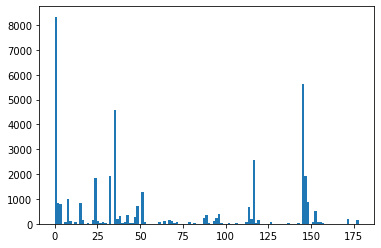

In [ ]:
plt.hist(y, bins=len(set(y)))

<ipython-input-9-5d39643d807a>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_set=labels.loc[:40000][~labels['filename'].isin(test_set['filename'])]


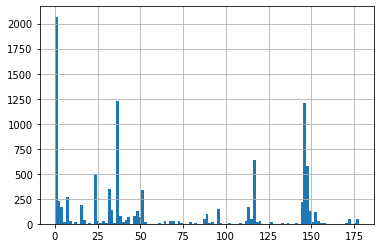

In [ ]:
seed=42
test_size=10000
test_set=labels.loc[:40000].sample(test_size, random_state=seed)## TODO exchange with train test split, with stratified classes
train_set=labels.loc[:40000][~labels['filename'].isin(test_set['filename'])]
test_set["y"].hist(bins=test_set["y"].nunique())

In [ ]:
labels["y"].nunique()

182

In [ ]:
y_onehot = keras.utils.to_categorical(y, num_classes=182)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(X, y,  batch_size=200)


In [ ]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_pred = self.model.predict(X_val)

        y_pred_cat = keras.utils.to_categorical(
            y_pred.argmax(axis=1),
            num_classes=182
        )

        _val_f1 = f1_score(y_val, y_pred_cat, average='macro')
        _val_recall = recall_score(y_val, y_pred_cat, average='macro')
        _val_precision = precision_score(y_val, y_pred_cat, average='macro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)

        print((f"val_f1: {_val_f1:.4f}"
               f" — val_precision: {_val_precision:.4f}"
               f" — val_recall: {_val_recall:.4f}"))

        return

f1_metrics = Metrics()

In [ ]:
  densenet = DenseNet121(
      weights='imagenet',
      include_top=False,
      input_shape=(256,256,3)
  )

In [ ]:
model = Sequential()
model.add(densenet)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(182, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 182)               186550    
                                                                 
Total params: 7,224,054
Trainable params: 7,140,406
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(
    DATA_PATH + 'model.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit(
    x=X,
    y=y,
    batch_size=64,
    epochs=7,
    callbacks=[checkpoint, f1_metrics],
    validation_split=0.1
)

Epoch 1/7


ValueError: ignored

In [ ]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df['val_f1'] = f1_metrics.val_f1s
history_df['val_precision'] = f1_metrics.val_precisions
history_df['val_recall'] = f1_metrics.val_recalls
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()
history_df[['val_f1', 'val_precision', 'val_recall']].plot()

In [ ]:
model.load_weights('model.h5')
y_test = model.predict(x_test)

submission_df = pd.read_csv('../input/iwildcam-2019-fgvc6/sample_submission.csv')
submission_df['Predicted'] = y_test.argmax(axis=1)

print(submission_df.shape)
submission_df.head()

In [ ]:
submission_df.to_csv('submission.csv',index=False)